<a href="https://colab.research.google.com/github/joynaomi81/Automatic-Essay-Scoring-AES-/blob/main/Automatic_Essay_Scoring_(AES).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets scikit-learn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Automated student assessment prize..csv")

In [ ]:
df.shape

(17307, 3)

In [ ]:
df.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [ ]:
df.drop(columns=["essay_id"], inplace=True)

In [ ]:
df.isnull().sum()

,0
full_text,0
score,0


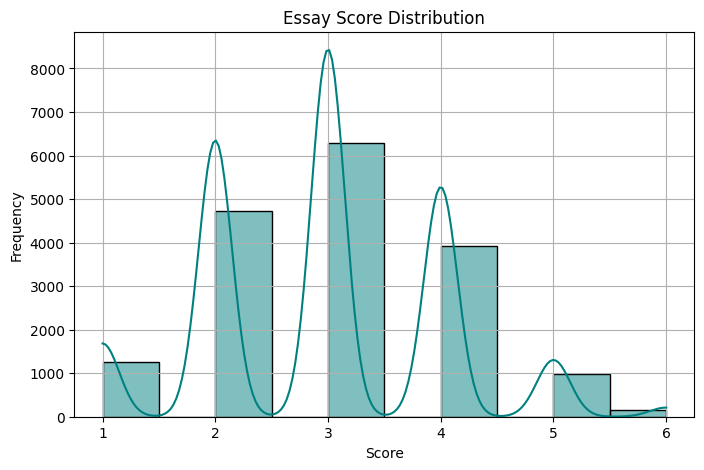

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['score'], kde=True, bins=10, color='teal')
plt.title('Essay Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

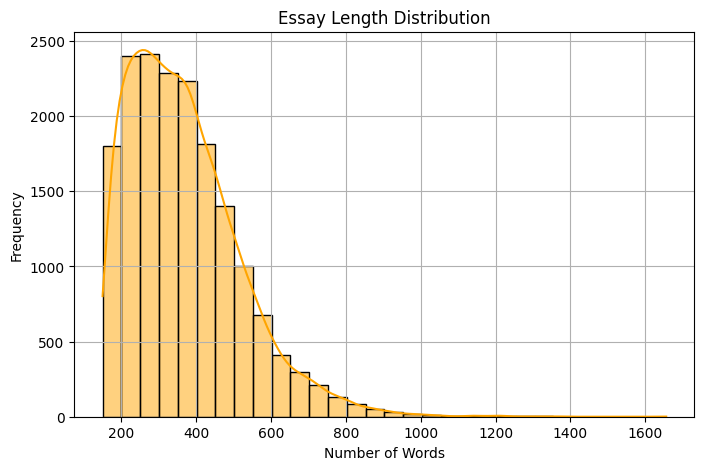

In [ ]:
df['essay_length'] = df['full_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,5))
sns.histplot(df['essay_length'], kde=True, bins=30, color='orange')
plt.title('Essay Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
import re
import string

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['full_text'] = df['full_text'].apply(clean_text)

# Print cleaned text
df['full_text'].head()


,full_text
0,many people have car where they live the thing...
1,i am a scientist at nasa that is discussing th...
2,people always wish they had the same technolog...
3,we all heard about venus the planet without al...
4,dear state senator this is a letter to argue i...


In [ ]:
from sklearn.model_selection import train_test_split

X = df['full_text']
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)

In [ ]:
import torch

class EssayDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

train_dataset = EssayDataset(train_encodings, list(y_train))
test_dataset = EssayDataset(test_encodings, list(y_test))

In [ ]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['full_text'].tolist(),
    df['score'].tolist(),
    test_size=0.2,
    random_state=42
)

In [ ]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors="pt")

In [ ]:
import torch

class EssayDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EssayDataset(train_encodings, train_labels)
val_dataset = EssayDataset(val_encodings, val_labels)

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=1  # For regression
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [ ]:
trainer.train()

Step,Training Loss
500,0.640600
1000,0.515700
1500,0.406400
2000,0.386400
2500,0.343900
3000,0.322000
3500,0.312400
4000,0.248700
4500,0.243600
5000,0.237500


TrainOutput(global_step=5193, training_loss=0.3602656851654082, metrics={'train_runtime': 453.2272, 'train_samples_per_second': 91.643, 'train_steps_per_second': 11.458, 'total_flos': 5501935282222080.0, 'train_loss': 0.3602656851654082, 'epoch': 3.0})

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.34798333048820496, 'eval_runtime': 11.1112, 'eval_samples_per_second': 311.578, 'eval_steps_per_second': 38.97, 'epoch': 3.0}


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error

In [ ]:
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    output = model(**inputs)
    return output.logits

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Get predictions from the model
predictions = trainer.predict(test_dataset)

# Extract predicted scores and true labels
y_pred = predictions.predictions.squeeze()
y_true = predictions.label_ids.squeeze()

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error (MSE): 0.3480
Mean Absolute Error (MAE): 0.4558
R² Score: 0.6846


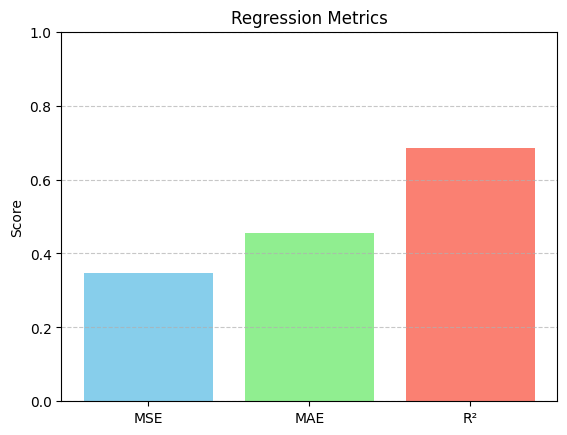

In [ ]:
import matplotlib.pyplot as plt

# Metrics
metrics = ['MSE', 'MAE', 'R²']
values = [0.3480, 0.4558, 0.6846]

# Plot
plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Regression Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Keep scale consistent
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

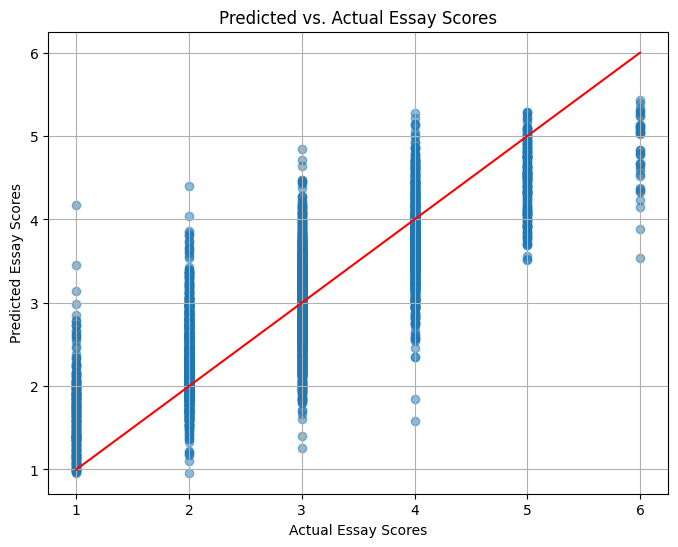

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.xlabel("Actual Essay Scores")
plt.ylabel("Predicted Essay Scores")
plt.title("Predicted vs. Actual Essay Scores")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')  # identity line
plt.grid(True)
plt.show()

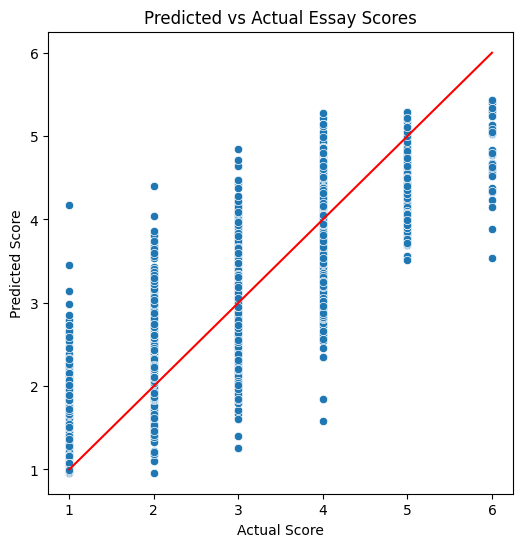

In [ ]:
# Scatter plot: Predicted vs Actual
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_true, y=y_pred)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual Essay Scores")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')
plt.show()



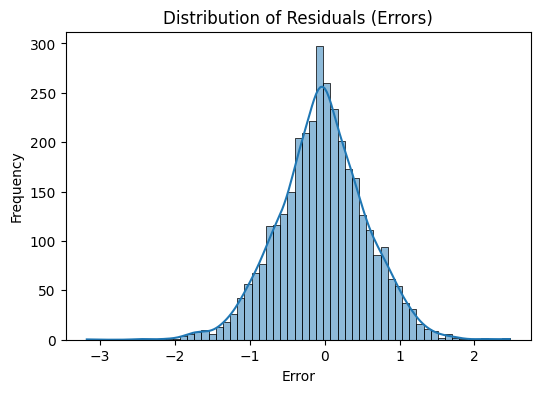

In [ ]:
#Residual histogram
residuals = np.array(y_true) - np.array(y_pred)
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals (Errors)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()


In [ ]:
import joblib

# Save model
joblib.dump(model, 'essay_scoring_model.pkl')

['essay_scoring_model.pkl']

In [ ]:
import joblib

model = joblib.load("essay_scoring_model.pkl")